In [1]:
import gym
import matplotlib.pyplot as plt
import collections
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from tensorflow import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.client import device_lib
from random import sample

from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK
import pickle

import pandas as pd
from openpyxl import load_workbook

print(tf.__version__)
print(device_lib.list_local_devices())

c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
c:\Users\Go\minic

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 895461768809825840
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 752525312
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14423686960712154286
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


### frozen lake (미끄러짐 x)
* s-a-ns-r 경우의 수가 몇가지 안되는데 중복되서 엄청나게 많은 경우의 수가 들어가는듯
* (비효율적)
* replay_buffer set으로 처리해서 중복값 어느정도 있는지 확인하고 처리해보기

In [2]:
def play_episodes_train(environ,q_net, epsilon,n_episode,opt,batch_size, ):   ## epsilon파트
    s = environ.reset()
    a = select_action(environ, q_net,epsilon, tf.one_hot([s], depth= 16, axis=-1), ismu = False)
    total_r = 0

    for _ in range(n_episode):
        while True:
            ns, r, done, info = environ.step(a)
            r_cum.append(r)
            if done:
                done = 1
            else:
                done = 0
            
            total_r += r

            replay_buffer.append([s,a,ns,r,done])
            
            if done == 1:
                s = environ.reset()
                a = select_action(environ, q_net,epsilon, tf.one_hot([s], depth= 16, axis=-1), ismu = False)
                
                break
            else:
                s = ns
                a = select_action(environ, q_net,epsilon, tf.one_hot([s], depth= 16, axis=-1), ismu = False)
            
            # epsilon = epsilon*0.99
            if len(replay_buffer)>batch_size:
                test = sample(replay_buffer, batch_size)
                test = np.array(test)
                with tf.GradientTape(watch_accessed_variables=True) as tape: 
                    q_val = tf.reshape(tf.gather_nd(q_network(tf.one_hot(test[:,0], depth= 16, axis=-1)),test[:,1].reshape([-1,1]).astype(np.int32),batch_dims=1,),[-1,1])
                    y =  test[:,3].reshape([-1,1]) + gamma * tf.reshape(tf.reduce_max(q_target_network(tf.one_hot(test[:,2], depth= 16, axis=-1)), axis=1), [-1,1]) * (1-test[:,4].reshape([-1,1]))
                    loss = h(y, q_val)
                grads = tape.gradient(loss, q_network.trainable_variables)
                opt.apply_gradients(zip(grads, q_network.trainable_variables))
                # 소프트 업데이트
                new_weights = [a + (b-a)*tau for a,b in zip(q_target_network.trainable_variables, q_network.trainable_variables)]
                q_target_network.set_weights(new_weights)

                
                loss_cum.append(loss)
   
    mean_reward = total_r/n_episode
    return mean_reward

# a = tf.convert_to_tensor([0,1,2,3,4,5,6,7],dtype=tf.int32)
# tf.one_hot([s], depth= 16, axis=-1)

def select_action(environ, q_net,epsilon, state, ismu):   # sarsa -> e-greedy policy
    best_action, best_value = None, None
    if ismu:
        # best_action = tf.math.argmax(q_net(tf.convert_to_tensor([[state],],dtype=tf.int32)), axis = 1).numpy()[0]
        # best_action = tf.math.argmax(q_net(tf.convert_to_tensor([[state,0],[state,1],[state,2],[state,3],],dtype=tf.int32))).numpy()[0]
        best_action = tf.math.argmax(q_net(state), axis = 1).numpy()[0]
        
        return best_action 


    else:
        if np.random.choice([True, False],p = [epsilon,1-epsilon]):
            action = environ.action_space.sample()
            return action
        else:
            # best_action = tf.math.argmax(q_net(tf.convert_to_tensor([[state],],dtype=tf.int32)), axis = 1).numpy()[0]
            # best_action = tf.math.argmax(q_net(tf.convert_to_tensor([[state,0],[state,1],[state,2],[state,3],],dtype=tf.int32))).numpy()[0]
            best_action = tf.math.argmax(q_net(state), axis = 1).numpy()[0]
            return best_action 
    
def make_dense_model(hidden_structure,input_shape,act_function,output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    for i, val in enumerate(hidden_structure):
        n_percep = val 
        if i == 0:
            # x = keras.layers.Dense(n_percep, activation= act_function)(inputs)
            x = keras.layers.Dense(n_percep,)(inputs)

        elif  i != 0 and i != len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep,)(x)

        elif  i == len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep,)(x)
            # x = keras.layers.Dense(n_percep)(x)
    x = keras.layers.Dense(output_shape)(x)

    dense_model = tf.keras.Model(inputs=inputs, outputs=x)
    return dense_model

In [134]:
%%time
env = gym.make("FrozenLake-v1", is_slippery = False)
max_step = 15
# env.render()
gamma = 0.9
alpha = 0.1
init_e = 1
n_epi = 20
# n_iter = 100
# batch_size = 128

# 모델 파라미터
hidden_structure= [32, 64, 32]
input_shape= 16
output_shape= 4
act_function= 'relu'
num_samples = 1
##시작
e = init_e
replay_buffer = []
#
mean_r_cum = []
loss_cum = []

#
# h = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
mse = tf.keras.losses.MeanSquaredError()
# 모델
lr_rate = 0.001
tau = 0.05
q_network = make_dense_model(hidden_structure,input_shape,act_function,output_shape)
q_target_network = make_dense_model(hidden_structure,input_shape,act_function,output_shape)
q_target_network.set_weights(q_network.trainable_variables)

optimizer= keras.optimizers.Adam(learning_rate=lr_rate)

CPU times: total: 62.5 ms
Wall time: 56 ms


In [135]:
environ,q_net, epsilon,n_episode,opt,batch_size, = env,q_network, e, n_epi, optimizer,batch_size
q_tgt =q_target_network

for _ in range(200):
    s = environ.reset()
    a = select_action(environ, q_net,epsilon, tf.one_hot([s], depth= 16, axis=-1), ismu = False)
    total_r = 0
    epsilon = epsilon*0.98
    for _ in range(n_episode):
        step_iter = 0
        while True:
            step_iter += 1
            if step_iter == max_step:
                s = environ.reset()
                a = select_action(environ, q_net,epsilon, tf.one_hot([s], depth= 16, axis=-1), ismu = False)
                break

            ns, r, done, info = environ.step(a)
            if done:
                done = 1
            else:
                done = 0
            
            total_r += r

            replay_buffer.append((s,a,ns,r,done))

            
            
            
            if done == 1:
                s = environ.reset()
                a = select_action(environ, q_net,epsilon, tf.one_hot([s], depth= 16, axis=-1), ismu = False)
                
                break
            else:
                s = ns
                a = select_action(environ, q_net,epsilon, tf.one_hot([s], depth= 16, axis=-1), ismu = False)

    counter = Counter(replay_buffer)
    train_set = list(counter.keys())
    test = np.array(train_set)

    with tf.GradientTape(watch_accessed_variables=True) as tape: 
        q_val = tf.reshape(tf.gather_nd(q_net(tf.one_hot(test[:,0], depth= 16, axis=-1)),test[:,1].reshape([-1,1]).astype(np.int32),batch_dims=1,),[-1,1])
        y =  test[:,3].reshape([-1,1]) + gamma * tf.reshape(tf.reduce_max(q_tgt(tf.one_hot(test[:,2], depth= 16, axis=-1)), axis=1), [-1,1]) * (1-test[:,4].reshape([-1,1]))
        
        # loss = h(y, q_val)
        loss = mse(y,q_val)
    grads = tape.gradient(loss, q_net.trainable_variables)
    opt.apply_gradients(zip(grads, q_net.trainable_variables))
    # 소프트 업데이트
    new_weights = [a + (b-a)*tau for a,b in zip(q_tgt.trainable_variables, q_net.trainable_variables)]
    q_tgt.set_weights(new_weights)

                
    loss_cum.append(loss)
    mean_reward = total_r/n_episode
    mean_r_cum.append(mean_reward)
    print(mean_reward)

0.0
0.05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.15
0.0
0.05
0.0
0.05
0.0
0.1
0.15
0.15
0.05
0.05
0.1
0.0
0.0
0.0
0.0
0.0
0.15
0.1
0.05
0.05
0.05
0.2
0.05
0.0
0.15
0.1
0.0
0.0
0.1
0.1
0.05
0.2
0.25
0.1
0.15
0.2
0.2
0.1
0.2
0.25
0.15
0.05
0.2
0.15
0.0
0.0
0.1
0.05
0.0
0.0
0.1
0.35
0.2
0.2
0.15
0.35
0.45
0.0
0.0
0.0
0.1
0.0
0.1
0.2
0.15
0.7
0.7
0.85
0.95
0.7
0.9
0.8
0.25
0.45
0.3
0.5
0.45
0.2
0.75
0.75
0.95
0.8
0.85
0.75
0.85
0.9
0.9
0.8
0.9
0.9
0.85
0.95
0.85
0.95
0.9
0.8
0.9
0.8
0.95
0.9
1.0
0.85
0.85
0.95
0.8
0.95
1.0
1.0
0.85
0.9
0.85
0.95
0.9
0.95
0.95
1.0
0.9
0.9
0.95
0.9
0.9
1.0
0.95
0.8
0.95
1.0
0.95
1.0
0.95
0.85
0.8
0.95
1.0
0.95
1.0
0.9
0.9
0.95
0.95
0.9
0.95
0.9
1.0
0.9
0.85
0.9
0.95
1.0
1.0
0.95
0.95
0.95
0.95
1.0
0.9
0.95
0.95
1.0
1.0
1.0
1.0
0.95
0.95
0.95
0.95
1.0
1.0
0.95
1.0
0.95
1.0
1.0
0.95
1.0
1.0
1.0
1.0
0.95
1.0
0.95
1.0
1.0
1.0


tf.Tensor(
[[ 4.7839257e-01  5.6657851e-01  5.5793375e-01  4.7704411e-01]
 [ 4.7858077e-01 -1.7973036e-04  6.4640445e-01  5.5922681e-01]
 [ 5.5826241e-01  7.3006618e-01  5.5878323e-01  6.4669728e-01]
 [ 6.4684486e-01 -5.1809102e-04  5.5962694e-01  5.5917424e-01]
 [ 5.6661189e-01  6.5111184e-01 -4.1776896e-04  4.7570267e-01]
 [ 1.3001980e-01  7.3589075e-01  4.0489858e-01  4.3754026e-01]
 [ 3.5015866e-04  8.1382090e-01  3.8736686e-04  6.4720559e-01]
 [ 7.9707193e-01  8.3748800e-01  6.0012311e-01  3.3446282e-01]
 [ 6.5318722e-01 -1.9448623e-04  7.3321640e-01  5.6708181e-01]
 [ 6.5224439e-01  8.1508946e-01  8.1419379e-01  5.4531358e-04]
 [ 7.3400766e-01  9.0317386e-01  1.0739621e-03  7.3199493e-01]
 [ 6.0644978e-01 -4.6623763e-02  5.3593427e-01  4.0410709e-02]
 [ 3.6641136e-01  1.9391422e-01  2.3621835e-01  8.7774858e-02]
 [ 1.2237690e-03  8.1522429e-01  9.0373516e-01  7.3409140e-01]
 [ 8.1628311e-01  9.0367860e-01  1.0013953e+00  8.1705409e-01]], shape=(15, 4), dtype=float32)
tf.Tensor(
[

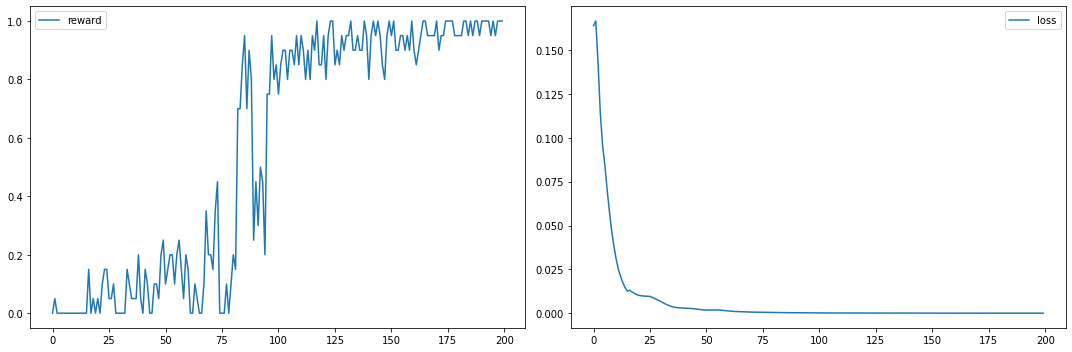

In [136]:
print(q_net(tf.one_hot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,],depth=16)))
print(q_tgt(tf.one_hot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,],depth=16)))
print(epsilon)
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(mean_r_cum, label='reward')
axes[0].legend()

axes[1].plot(loss_cum, label='loss')
axes[1].legend()
fig.tight_layout()

### frozen lake (미끄러짐 O)
* s-a-ns-r 경우의 수가 몇가지 안되는데 중복되서 엄청나게 많은 경우의 수가 들어가는듯
* (비효율적)
* replay_buffer set으로 처리해서 중복값 어느정도 있는지 확인하고 처리해보기
* 동일 (s,a)에 대해 3가지 정답 label존재함 (평균에러가 낮아지게 학습)

In [3]:
%%time
# {'e_grad': 0.9367468819972083, 'gamma': 0.8934878423529162, 'lr_rate': 0.0006182836160053605, 'tau': 0.04568867085600904}
env = gym.make("FrozenLake-v1", is_slippery = True)
# env.render()
gamma = 0.89
alpha = 0.1
init_e = 1
n_epi = 20
# n_iter = 100
# batch_size = 128

# 모델 파라미터
hidden_structure= [32, 128, 256,  128, 32]
input_shape= 16
output_shape= 4
act_function= 'relu'
num_samples = 1
##시작
e = init_e
replay_buffer = []
#
mean_r_cum = []
loss_cum = []

#
# h = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
mse = tf.keras.losses.MeanSquaredError()
# 모델
lr_rate = 0.00062
tau = 0.046
q_network = make_dense_model(hidden_structure,input_shape,act_function,output_shape)
q_target_network = make_dense_model(hidden_structure,input_shape,act_function,output_shape)
q_target_network.set_weights(q_network.trainable_variables)

optimizer= keras.optimizers.Adam(learning_rate=lr_rate)

CPU times: total: 125 ms
Wall time: 229 ms


In [4]:
environ,q_net, epsilon,n_episode,opt, = env,q_network, e, n_epi, optimizer
q_tgt =q_target_network

for _ in range(100):
    # if _ > 80 : epsilon = epsilon*0.98
    epsilon = epsilon*0.93
    s = environ.reset()
    a = select_action(environ, q_net,epsilon, tf.one_hot([s], depth= 16, axis=-1), ismu = False)
    total_r = 0
    
    for _ in range(n_episode):
        
        while True:
            ns, r, done, info = environ.step(a)
            if done:
                done = 1
            else:
                done = 0
            
            total_r += r

            replay_buffer.append((s,a,ns,r,done))

            
            
            
            if done == 1:
                s = environ.reset()
                a = select_action(environ, q_net,epsilon, tf.one_hot([s], depth= 16, axis=-1), ismu = False)
                
                break
            else:
                s = ns
                a = select_action(environ, q_net,epsilon, tf.one_hot([s], depth= 16, axis=-1), ismu = False)

    counter = Counter(replay_buffer)
    train_set = list(counter.keys())
    test = np.array(train_set)

    with tf.GradientTape(watch_accessed_variables=True) as tape: 
        q_val = tf.reshape(tf.gather_nd(q_net(tf.one_hot(test[:,0], depth= 16, axis=-1)),test[:,1].reshape([-1,1]).astype(np.int32),batch_dims=1,),[-1,1])
        y =  test[:,3].reshape([-1,1]) + gamma * tf.reshape(tf.reduce_max(q_tgt(tf.one_hot(test[:,2], depth= 16, axis=-1)), axis=1), [-1,1]) * (1-test[:,4].reshape([-1,1]))
        
        # loss = h(y, q_val)
        loss = mse(y,q_val)
    grads = tape.gradient(loss, q_net.trainable_variables)
    opt.apply_gradients(zip(grads, q_net.trainable_variables))
    # 소프트 업데이트
    new_weights = [a + (b-a)*tau for a,b in zip(q_tgt.trainable_variables, q_net.trainable_variables)]
    q_tgt.set_weights(new_weights)
    
                
    loss_cum.append(loss)
    mean_reward = total_r/n_episode
    mean_r_cum.append(mean_reward)
    print(mean_reward)
    if mean_reward >= 0.7:
        break

0.1
0.0
0.0
0.0
0.05
0.05
0.1
0.05
0.05
0.05
0.05
0.0
0.05
0.0
0.0
0.05
0.05
0.05
0.1
0.0
0.05
0.1
0.2
0.0
0.05
0.0
0.0
0.1
0.1
0.15
0.2
0.1
0.2
0.05
0.05
0.05
0.0
0.25
0.45
0.4
0.2
0.35
0.15
0.0
0.0
0.0
0.0
0.0
0.65
0.7


tf.Tensor(
[[ 0.12064983  0.07114603  0.09012958  0.10756653]
 [ 0.05751877  0.04229823  0.06718183  0.07313529]
 [ 0.06434196  0.0586663   0.05557789  0.04908772]
 [ 0.03575616  0.03916728  0.03563655  0.05494689]
 [ 0.11457735  0.10632679  0.11136959  0.04900839]
 [-0.14941609 -0.07818568  0.1170768   0.00286163]
 [ 0.07593746  0.04644552  0.07826872  0.01623662]
 [-0.17277177  0.21878485  0.26943818  0.38193497]
 [ 0.10002428  0.08705751  0.09792402  0.11564529]
 [ 0.13597785  0.22456864  0.14211404  0.1601925 ]
 [ 0.21284716  0.19296524  0.15705822  0.04282581]
 [ 0.16848846  0.16950355  0.09077518  0.04039009]
 [ 0.31893063 -0.03187409 -0.03538083 -0.1768031 ]
 [ 0.127311    0.23477142  0.27426946  0.18343134]
 [ 0.18901572  0.5644276   0.5290012   0.49107042]], shape=(15, 4), dtype=float32)
tf.Tensor(
[[ 0.10723848  0.07280302  0.11076228  0.09763651]
 [ 0.051753    0.03670661  0.07259686  0.09687354]
 [ 0.052338    0.05149626  0.03579759  0.06138268]
 [ 0.03424915  0.03483984  0

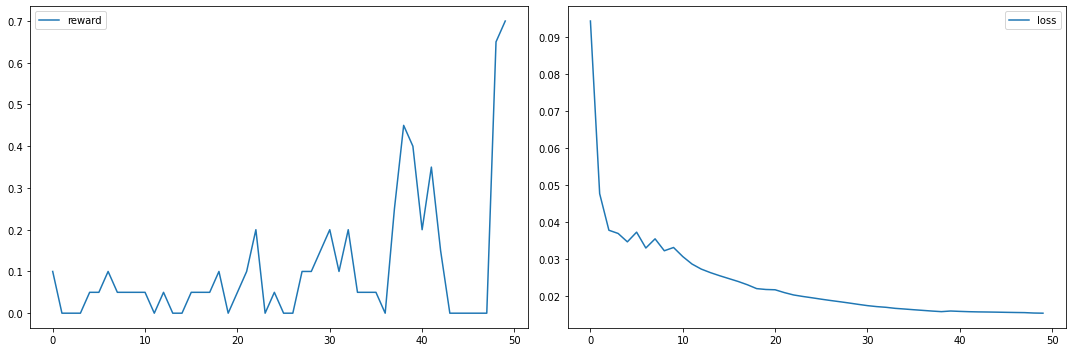

In [5]:
print(q_net(tf.one_hot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,],depth=16)))
print(q_tgt(tf.one_hot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,],depth=16)))
print(epsilon)
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(mean_r_cum, label='reward')
axes[0].legend()

axes[1].plot(loss_cum, label='loss')
axes[1].legend()
fig.tight_layout()

In [46]:
s = environ.reset()
environ.render()

In [282]:
# tf.reduce_max(q_tgt(tf.one_hot([0], depth= 16, axis=-1)), axis=1)
# a = tf.math.argmax(q_tgt(tf.one_hot([s], depth= 16, axis=-1)), axis = 1).numpy()[0]
a = select_action(environ, q_tgt,epsilon, tf.one_hot([s], depth= 16, axis=-1), ismu = True)
ns, r, done, info = environ.step(a)
s = ns
environ.render()

: 

In [104]:
environ.close()

### 파라미터찾기

In [743]:
def search_params(args):
    print("CHECK!!")
    e_grad,gamma,tau,lr_rate = args
    

    env = gym.make("FrozenLake-v1", is_slippery = True)
    # env.render()
    
    init_e = 1
    n_epi = 20
    # n_iter = 100
    # batch_size = 128

    # 모델 파라미터
    hidden_structure= [32, 128, 256,  128, 32]
    input_shape= 16
    output_shape= 4
    act_function= 'relu'
    ##시작
    e = init_e
    replay_buffer = []
    #
    mean_r_cum = []
    loss_cum = []

    #
    # h = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
    mse = tf.keras.losses.MeanSquaredError()
    # 모델
    q_network = make_dense_model(hidden_structure,input_shape,act_function,output_shape)
    q_target_network = make_dense_model(hidden_structure,input_shape,act_function,output_shape)
    q_target_network.set_weights(q_network.trainable_variables)

    optimizer= keras.optimizers.Adam(learning_rate=lr_rate)

    #####
    environ,q_net, epsilon,n_episode,opt, = env,q_network, e, n_epi, optimizer,
    q_tgt =q_target_network

    

    for _ in range(100):
        # if _ > 80 : epsilon = epsilon*0.98
        epsilon = epsilon*e_grad
        s = environ.reset()
        a = select_action(environ, q_net,epsilon, tf.one_hot([s], depth= 16, axis=-1), ismu = False)
        total_r = 0
        
        for _ in range(n_episode):
            
            while True:
                ns, r, done, info = environ.step(a)
                if done:
                    done = 1
                else:
                    done = 0
                
                total_r += r

                replay_buffer.append((s,a,ns,r,done))

                
                
                
                if done == 1:
                    s = environ.reset()
                    a = select_action(environ, q_net,epsilon, tf.one_hot([s], depth= 16, axis=-1), ismu = False)
                    
                    break
                else:
                    s = ns
                    a = select_action(environ, q_net,epsilon, tf.one_hot([s], depth= 16, axis=-1), ismu = False)
        
        counter = Counter(replay_buffer)
        train_set = list(counter.keys())
        test = np.array(train_set)

        with tf.GradientTape(watch_accessed_variables=True) as tape: 
            q_val = tf.reshape(tf.gather_nd(q_net(tf.one_hot(test[:,0], depth= 16, axis=-1)),test[:,1].reshape([-1,1]).astype(np.int32),batch_dims=1,),[-1,1])
            y =  test[:,3].reshape([-1,1]) + gamma * tf.reshape(tf.reduce_max(q_tgt(tf.one_hot(test[:,2], depth= 16, axis=-1)), axis=1), [-1,1]) * (1-test[:,4].reshape([-1,1]))
            
            # loss = h(y, q_val)
            loss = mse(y,q_val)
       
        grads = tape.gradient(loss, q_net.trainable_variables)
        opt.apply_gradients(zip(grads, q_net.trainable_variables))
        # 소프트 업데이트
        new_weights = [a + (b-a)*tau for a,b in zip(q_tgt.trainable_variables, q_net.trainable_variables)]
        q_tgt.set_weights(new_weights)
    
                    
        loss_cum.append(loss)
        mean_reward = total_r/n_episode
        mean_r_cum.append(mean_reward)
    
    result = sum(mean_r_cum[-10:]) / len(mean_r_cum[-10:])
    return(-1*result)

In [744]:
space = [hp.uniform('e_grad',0.8,0.98),            
         hp.uniform('gamma',0.7,0.9),          
         hp.uniform('tau',0.005,0.05),                
         hp.uniform('lr_rate',0.0001,0.001), 
         ]

In [745]:
%%time
trials=Trials()
# trials = pickle.load(open('result.p', "rb"))    #trials불러오기
eval_it = 100
best = fmin(search_params,space,algo=tpe.suggest,max_evals=eval_it,trials=trials)
pickle.dump(trials, open("result.p", "wb"))     
print(best)
print(space_eval(space, best))

CHECK!!                                                
CHECK!!                                                               
CHECK!!                                                               
CHECK!!                                                               
CHECK!!                                                                    
CHECK!!                                                                    
CHECK!!                                                                   
CHECK!!                                                                   
CHECK!!                                                                   
CHECK!!                                                                  
CHECK!!                                                                   
CHECK!!                                                                   
CHECK!!                                                                   
CHECK!!                                                

In [3]:
trials = pickle.load(open('result.p', "rb"))

In [13]:
# trials = pickle.load(open('result.p', "rb"))
tresults = pd.DataFrame({'iteration':trials.idxs_vals[0]['e_grad'],
                              'e_grad':trials.idxs_vals[1]['e_grad'],'gamma':trials.idxs_vals[1]['gamma'],'lr_rate':trials.idxs_vals[1]['lr_rate'],'tau':trials.idxs_vals[1]['tau'],
                              'mean_loss':[x['loss'] for x in trials.results]})
#tresults["t_result"] = t_results

#엑셀에 저장
#writer = pd.ExcelWriter(path+site+'optimization_results/'+resultfilename)#,engine=xlsxwriter)
book = load_workbook('search_hist.xlsx')
writer = pd.ExcelWriter('search_hist.xlsx',engine='openpyxl')
writer.book = book
#
tresults.to_excel(writer, sheet_name = 'search_hist')
writer.save()
writer.close()
      

In [25]:
import plotly.express as px
import plotly.graph_objects as go

data = pd.read_excel("search_hist.xlsx", sheet_name = 'search_hist')
data.loc[:,'mean_loss'] = -1*data.loc[:,'mean_loss']
data
fig = px.parallel_coordinates(data, color="mean_loss", dimensions=data.columns,
                              color_continuous_scale=px.colors.sequential.Blues,
                              title="Optimization result",
                              range_color=[0,0.3]
                          
                              )

fig.write_html('search_hist_pall.html')